In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import cv2

# File and directory handling libraries
import pydicom
from os import listdir

# Statistical and data processing libraries
from scipy.stats import mode, skew
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Progress tracking and warning suppression libraries
from tqdm.notebook import trange
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seaborn style
sns.set_style('darkgrid')

# Analysis of patient metadata

The test set only contains an example for a single patient. Let's only focus on the train set.

In [2]:
filepath = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
data = pd.read_csv(filepath)
data.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

## Missing values 

In [3]:
data.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

There are missing values only for age, BIRADS and density.

In [4]:
num_patients = data['patient_id'].nunique()
min_patient_age = int(data['age'].min())
max_patient_age = int(data['age'].max())
groupby_id = data.groupby('patient_id')['cancer'].max()
n_negative = (groupby_id == 0).sum()
n_positive = (groupby_id == 1).sum()

print(f"There are {num_patients} different patients in the train set.\n")
print(f"The younger patient is {min_patient_age} years old.")
print(f"The older patient is {max_patient_age} years old.\n")
print(f"There are {n_negative} patients negative to breast cancer. Ratio = {n_negative / num_patients}")
print(f"There are {n_positive} patients positive to breast cancer. Ratio = {n_positive / num_patients}")

There are 11913 different patients in the train set.

The younger patient is 26 years old.
The older patient is 89 years old.

There are 11427 patients negative to breast cancer. Ratio = 0.9592042306723747
There are 486 patients positive to breast cancer. Ratio = 0.040795769327625284


The classification problem is very unbalanced. About 4% of the patients are in the positive class which means that we will have a minority of cancer examples.

## Age distribution

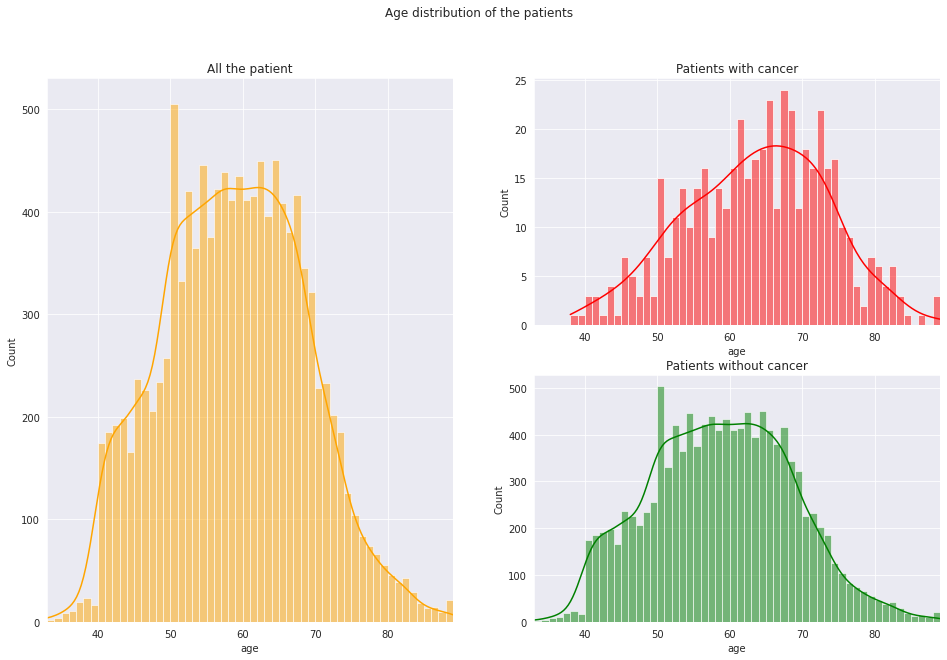

In [5]:
ages = data.groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
cancer_ages = data[data['cancer'] == 1].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
no_cancer_ages = data[data['cancer'] == 0].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.histplot(ages, bins=63, color='orange', kde=True)
plt.title("All the patient")
plt.xlim(33, 89)

plt.subplot(2, 2, 2)
sns.histplot(cancer_ages, bins=51, color='red', kde=True)
plt.title("Patients with cancer")
plt.xlim(33, 89)

plt.subplot(2, 2, 4)
sns.histplot(no_cancer_ages, bins=63, color='green', kde=True)
plt.title("Patients without cancer")
plt.xlim(33, 89)

plt.suptitle("Age distribution of the patients")
plt.show()

Notice that the age distribution of the patients with a breast cancer is **negatively skewed** compared to the healthy ones.

In [6]:
# Statistics
print("Mean:", ages.mean())
print("Std:", ages.std())
print("Q1:", ages.quantile(0.25))
print("Median:", ages.median())
print("Q3:", ages.quantile(0.75))
print("Mode:", ages.mode()[0])

Mean: 58.63821923561529
Std: 9.885104442511699
Q1: 51.0
Median: 59.0
Q3: 66.0
Mode: 50.0


### Insights
- Most of the patients are **older than 40 years old**
- There is a a **peak at the age of 50**
- Then, there is a **plateau until 70 years old** before the count of patients drops
- **Patients with cancer** are usually **older** than the others
- **Age will be an important feature** for a future model

## Number of images per patient

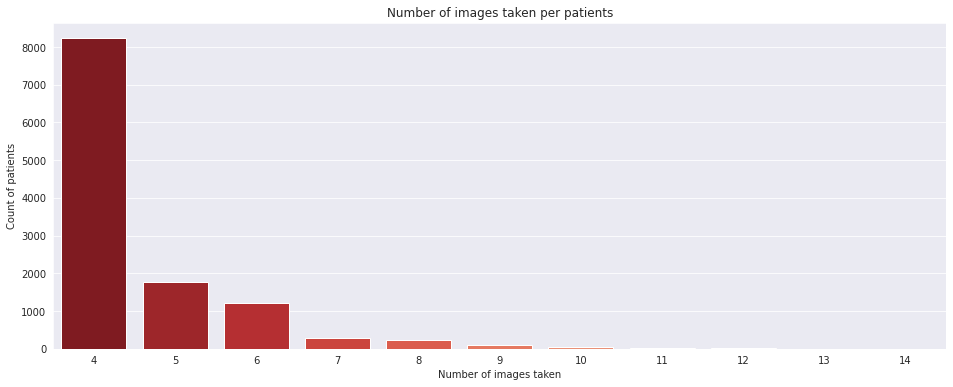

In [7]:
n_images_per_patient = data['patient_id'].value_counts()
plt.figure(figsize=(16, 6))
sns.countplot(n_images_per_patient, palette='Reds_r')
plt.title("Number of images taken per patients")
plt.xlabel('Number of images taken')
plt.ylabel('Count of patients')
plt.show()

### Insights
* Most of the patients have 4 images (2 views per side). However there are sometimes more of them.

## Image features

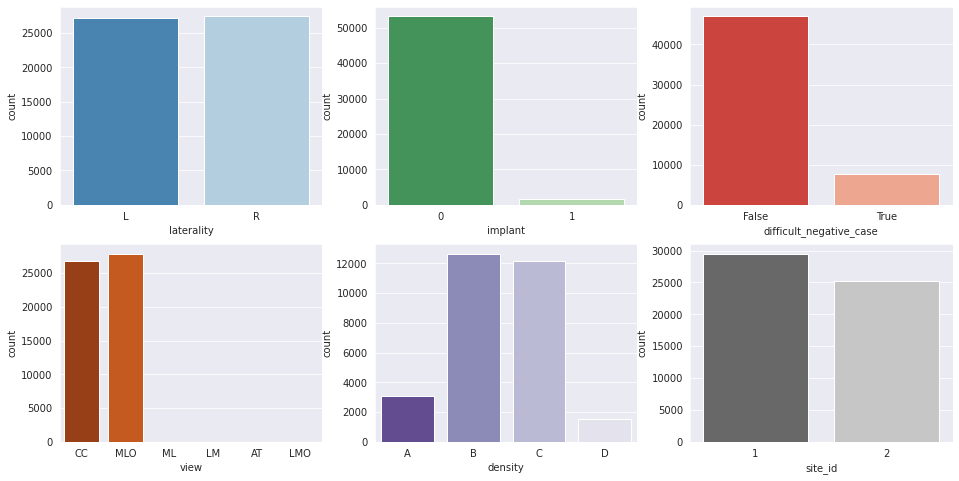

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(data['laterality'], palette='Blues_r', ax=ax[0, 0])
sns.countplot(data['implant'], palette='Greens_r', ax=ax[0, 1])
sns.countplot(data['difficult_negative_case'], palette='Reds_r', ax=ax[0, 2])
sns.countplot(data['view'], palette='Oranges_r', ax=ax[1, 0])
sns.countplot(data['density'], palette='Purples_r', order=['A', 'B', 'C', 'D'], ax=ax[1, 1])
sns.countplot(data['site_id'], palette='Greys_r', ax=ax[1, 2])
plt.show()

### Insights
* The pictures are balanced in term of laterality
* Only a few images have implents
* Some images were difficult to diagnose
* There are usually only two types of views which are CC and MLO
* There is a minority of images where the breast tissus density is very large (D) or very low (A). Most of the time, the density is in the middle (B) and (C)
* Images where taken in two different sites in a balanced way

## Target features

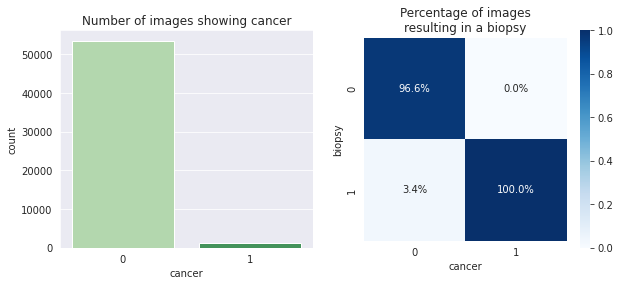

In [9]:
biopsy_counts = data.groupby('cancer')['biopsy'].value_counts().unstack().fillna(0)
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data['cancer'], palette='Greens', ax=ax[0])
sns.heatmap(biopsy_perc, square=True, annot=True, fmt='.1%', cmap='Blues', ax=ax[1])
ax[0].set_title("Number of images showing cancer")
ax[1].set_title("Percentage of images\nresulting in a biopsy")
plt.show()

### Insights
* The number of sample images with cancer is very low compared to the number of healthy breast samples. It will be more difficult to make the model learn the desired pattern.
* All patients with a cancer had a biopsy
* Only a small percentage of images without cancer resulted in a biopsy

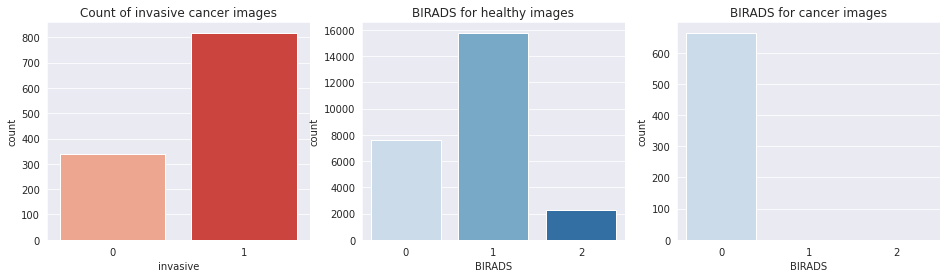

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data[data['cancer'] == True]['invasive'], ax=ax[0], palette='Reds')
sns.countplot(data[data['cancer'] == False]['BIRADS'], order=[0, 1, 2], ax=ax[1], palette='Blues')
sns.countplot(data[data['cancer'] == True]['BIRADS'], order=[0, 1, 2], ax=ax[2], palette='Blues')
ax[0].set_title("Count of invasive cancer images")
ax[1].set_title("BIRADS for healthy images")
ax[2].set_title("BIRADS for cancer images")
plt.show()

BIRADS value signification:
* 0: required follow-up
* 1: rated as negative for cancer
* 2: rated as normal

### Insights
* Most of the images with cancer are invasive
* A few healthy images led to a follow-up
* All cancer images needed a follow-up

## Machine IDs

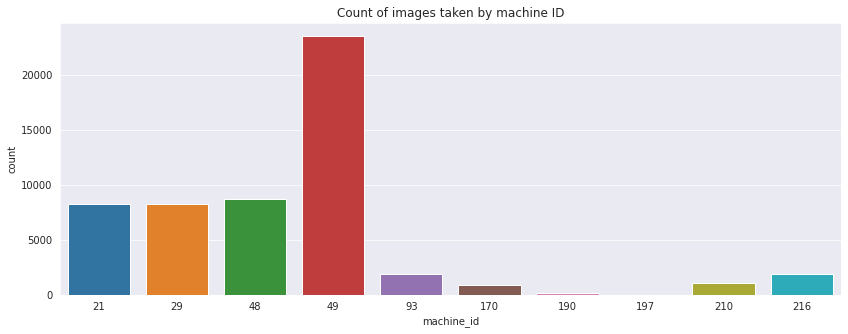

In [11]:
plt.figure(figsize=(14, 5))
sns.countplot(data['machine_id'])
plt.title("Count of images taken by machine ID")
plt.show()

### Insights
* The images were taken from 10 different machines
* Most of the images are from machine 49, 21, 29 and 48
* Machine difference can lead to image distribution difference

# Analysis of the image data

### DICOM files
The image data is in DICOM format. **DICOM (Digital Imaging and Communications in Medicine)** is a standard for storing and transmitting medical images and related information.

In [12]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

## Getting all scans of a single patient

In [13]:
def load_patient_scans(path, patient_id):
    patient_path = path + '/' + str(patient_id)
    return [pydicom.dcmread(patient_path + '/' + file) for file in listdir(patient_path)]

We can now load all the scans for the first patient that we will use for exploring.

In [14]:
# Load all scans of the twelfth patient
patient_ids = data['patient_id'].unique()
scans = load_patient_scans(train_path, patient_ids[11])

## Raw pixelarrays

Let's check the pixel distribution of an image.

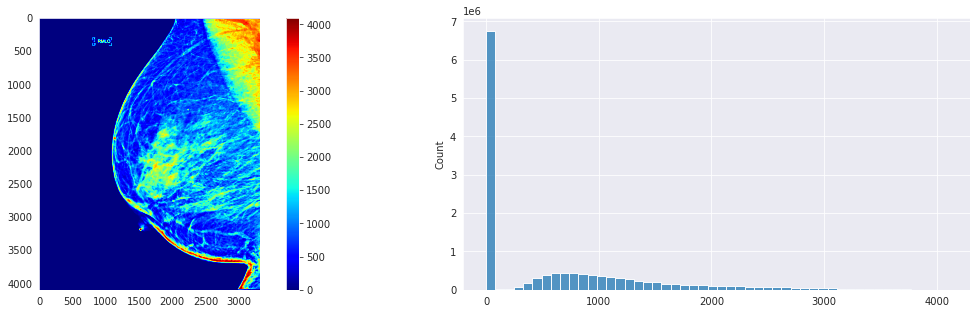

In [15]:
# Look at raw pixelarrays
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im = ax[0].imshow(scans[0].pixel_array, cmap='jet')
ax[0].grid(False)
fig.colorbar(im, ax=ax[0])
sns.histplot(scans[0].pixel_array.flatten(), ax=ax[1], bins=50)
plt.show()

The value of the background is zero. This means that the raw pixelarray is not in HU. Some values are very large compared to what we would expect for soft tissues. The images should be converted to HU in order to have something consistant.

Let's dive deep into the different machine IDs.

In [16]:
def get_scan_info():
    modes, rows, cols = [], [], []
    machine_ids = data['machine_id'].unique()
    for m_id in machine_ids:
        m_id_modes, m_id_rows, m_id_cols = [], [], []
        print(f"Machine id {m_id} in progress")
        patient_ids = data[data['machine_id'] == m_id]['patient_id'].unique()
        for n in range(50):
            try:
                scan = load_patient_scans(train_path, patient_ids[n])[0]
                m_id_modes.append(mode(scan.pixel_array.flatten())[0][0])
                m_id_rows.append(scan.Rows)
                m_id_cols.append(scan.Columns)
            except IndexError:
                break
        modes.append(m_id_modes)
        rows.append(m_id_rows)
        cols.append(m_id_cols)
    return modes, rows, cols

In [17]:
modes, rows, cols = get_scan_info()

machine_ids = data['machine_id'].unique()
medians = [np.median(x) for x in modes]
stds = [np.std(x) for x in modes]
rows = [np.mean(x) for x in rows]
cols = [np.mean(x) for x in cols]
df = pd.DataFrame(data={'Machine ID': machine_ids, 'Mode (median)': medians, 'Mode (std)': stds, 'Rows (mean)': rows, 'Cols (mean)': cols})
df.astype(int).set_index('Machine ID').T

Machine id 29 in progress
Machine id 21 in progress
Machine id 216 in progress
Machine id 93 in progress
Machine id 49 in progress
Machine id 48 in progress
Machine id 170 in progress
Machine id 210 in progress
Machine id 190 in progress
Machine id 197 in progress


Machine ID      29    21    216   93    49    48    170   210   190   197
Mode (median)  3524     0     0     0     0     0     0  1017     0    83
Mode (std)      215     0   146   289     0     0     0     2    67   219
Rows (mean)    5355  2776  2294  2831  3834  4096  3804  5072  2322  2213
Cols (mean)    4915  2082  1914  2250  3066  3328  3036  3872  1931  1843

### Insights
* It seems that the pixel distribution is different based on the machine ID. In fact, the mode corresponds to the background pixels. Most of the time, this value is calibrated to 0 but for some machines (e.g. IDs 29 and 210), it is above a 3000 and 1000 respectively.
* The value of Photometric Interpretation must be observed. There are 2 types:
 - In a *MONOCHROME1* image, the pixel values represent the grayscale values of the image, with higher values corresponding to brighter pixels and lower values corresponding to darker pixels.
 - In a *MONOCHROME2* image, the pixel values are reversed, with higher values corresponding to darker pixels and lower values corresponding to brighter pixels.
* The image size also depends on the machine. Again, machines 29 and 210 have a high resolution compared to others like machine IDs 216 and 197.
* It will be necessary to normalize the image size and the pixel values in order to train a robust model.

## Display examples for different machines

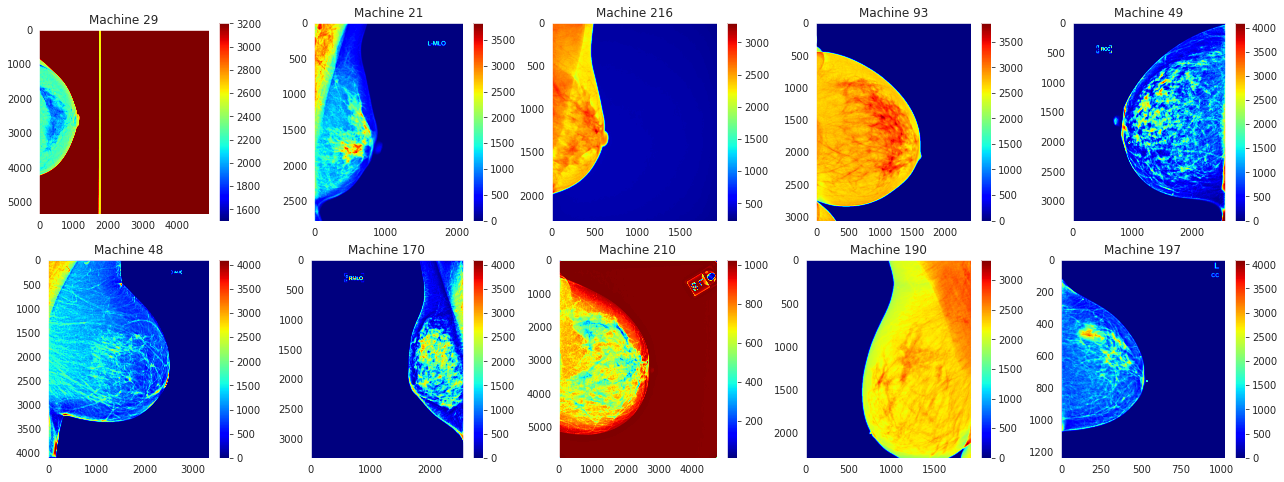

In [18]:
plt.figure(figsize=(22, 8))
for i, m_id in enumerate(machine_ids):
    patient_ids = data[data['machine_id'] == m_id]['patient_id'].unique()
    scan = load_patient_scans(train_path, patient_ids[0])[0] # Load first scan of first patient
    plt.subplot(2, 5, i+1)
    plt.imshow(scan.pixel_array, cmap='jet')
    plt.title(f"Machine {m_id}")
    plt.colorbar()
    plt.grid(False)
plt.show()

### Insights
* For machines 29 and 210, the background values seem to be switched. In other words, it appears to be the highest value (white color). For the other images, it appears to be the lowest value (black color). This should be taken into account during processing.
* These images are just one example for each machine. It could be also different for other examples.

### Tips
* It is possible to fix the photometric interpretation by applying these formulas to the pixelarrays:
 - If MONOCRHOME1:
 >array = array.max() - array
 - If MONOCHROME2:
 >array = array - array.min()
 
This makes the way all the images are interpreted the same. The background of the images will be set to zero.

## Images showing implants

In this dataset, there are scans of breasts with implants. It can be interesting to have a look at them and compare them with other scans.

In [19]:
m_id_implants = data[data['implant'] == 1]['machine_id'].unique()
print("Scans showing implents are from machines", m_id_implants)

Scans showing implents are from machines [ 49 170]


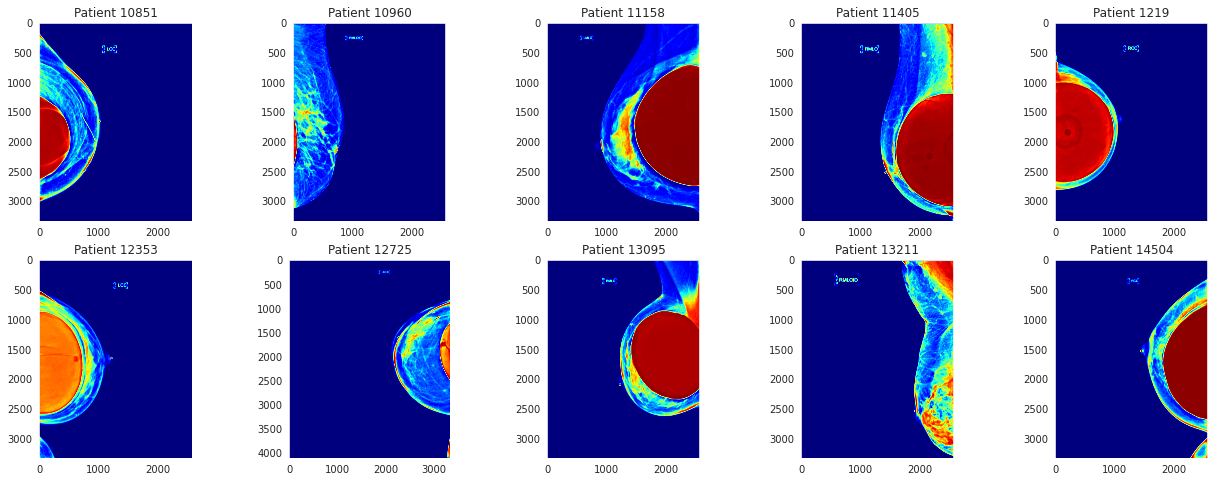

In [20]:
patient_ids = data[data['implant'] == 1]['patient_id'].unique()

# Display scans showing implants
plt.figure(figsize=(22, 8))
for i in range(10):
    scan = load_patient_scans(train_path, patient_ids[i])[0] # Load first scan of the patient
    plt.subplot(2, 5, i+1)
    plt.imshow(scan.pixel_array, cmap='jet')
    plt.title(f"Patient {patient_ids[i]}")
    plt.grid(False)
plt.show()

The implant is distinguished by the white mass in the breast. However, it is sometimes not very easy to see it like with patients 10960 and 13095.

Let's check all the scans of a single patient having implant.

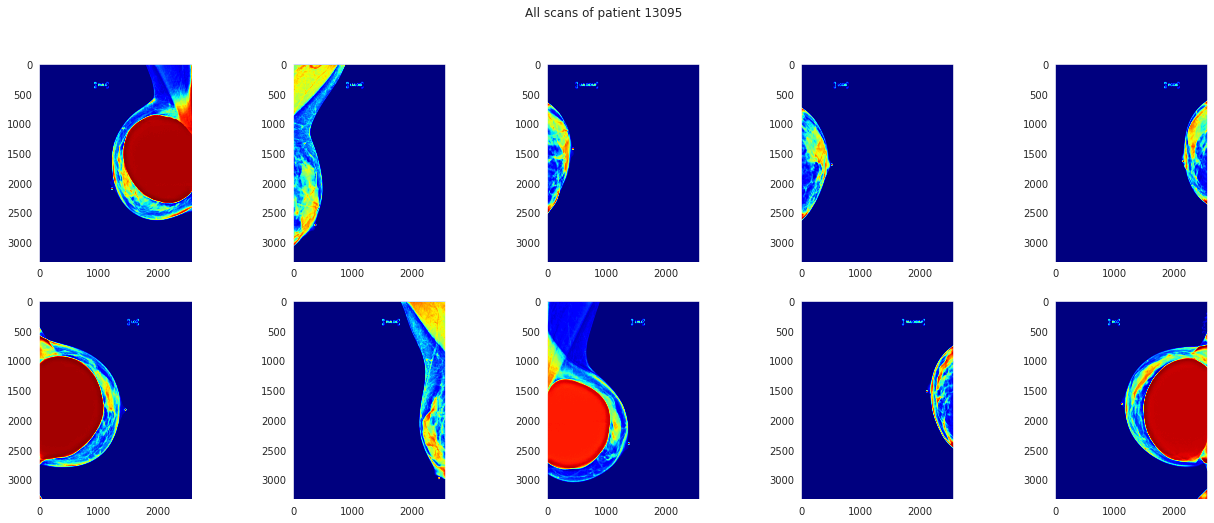

In [21]:
# Display scans of patient 13095
plt.figure(figsize=(22, 8))
scans = load_patient_scans(train_path, 13095)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(scans[i].pixel_array, cmap='jet')
    plt.grid(False)
plt.suptitle("All scans of patient 13095")
plt.show()

### Insights
* All the scans showing implants are from machines 49 and 170.
* The implants are sometimes only present on one side and not in both breasts for a given patient.
* The metadata does not specify the presence of implent for a scan but for a given patient. It is therefore likely that an image without an implant indicates its presence.

## Images with cancer

In [22]:
# Choose to display images with or without cancer
def display_cancer_or_not(cancer=True):
    cancer_scans = data[data['cancer'] == int(cancer)].sample(frac=1, random_state=0)
    plt.figure(figsize=(22, 10))
    for i in trange(10):
        patient = str(cancer_scans.iloc[i][['patient_id']][0])
        file = str(cancer_scans.iloc[i][['image_id']][0]) + '.dcm'
        scan = pydicom.dcmread(train_path + '/' + patient + '/' + file)
        plt.subplot(2, 5, i+1)
        plt.imshow(scan.pixel_array, cmap='jet')
        plt.title(f"Patient {patient}\nScan {file}")
        plt.grid(False)
    plt.suptitle(f"Cancer = {cancer}")
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

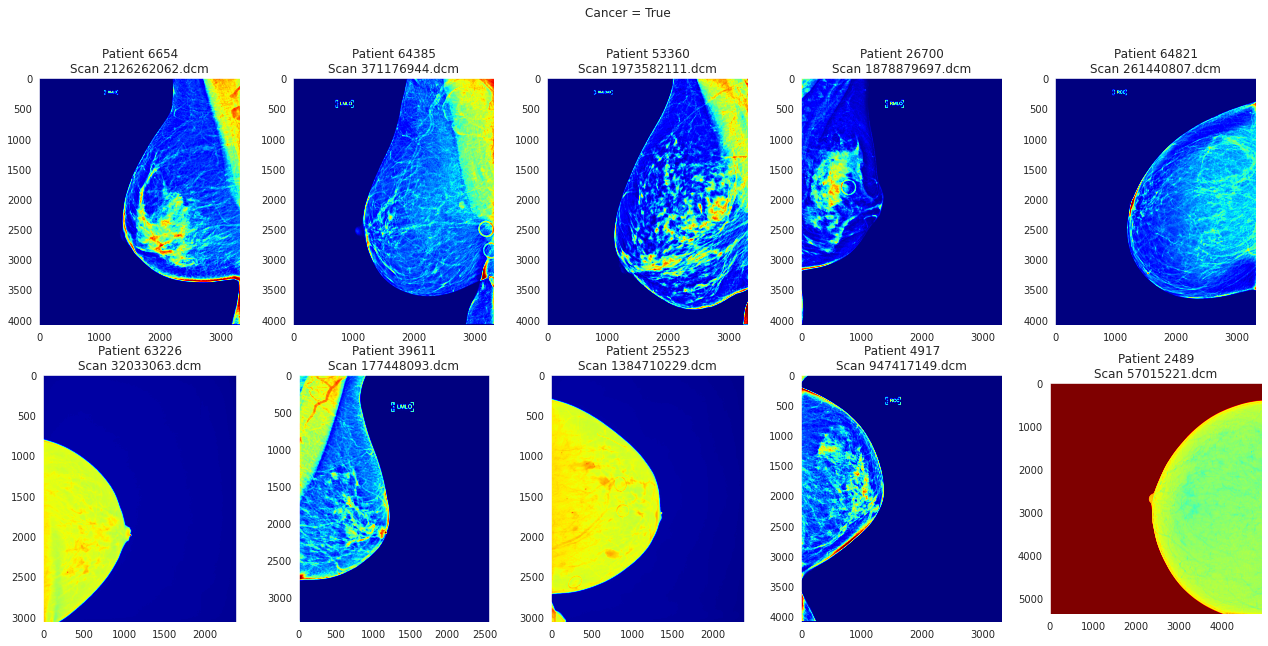

In [23]:
# Images with cancer
display_cancer_or_not(cancer=True)

  0%|          | 0/10 [00:00<?, ?it/s]

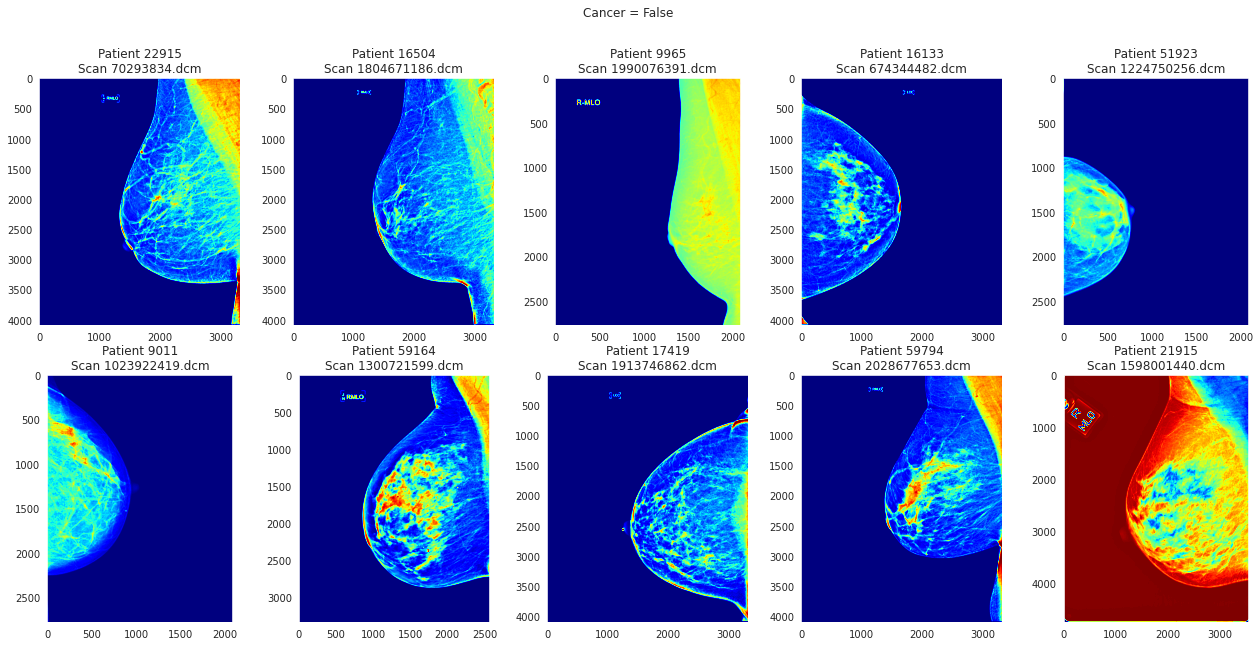

In [24]:
# Images without cancer
display_cancer_or_not(cancer=False)

### Insights
* It is impossible for me to distinguish by eye an image with cancer from a healthy image
* Again, there are images from different machine IDs which results in different pixel distributions

## Outliers analysis
To improve the performance of our future model, we also could focus on identifying and removing outliers. One approach to accomplish this is to create a table containing various statistical data on the distribution of pixels in the images. By comparing these statistics, we can quickly identify images that deviate significantly from the norm and eliminate them as outliers.

This task can be very computational expensive and this is why I will do it on just a small part of the patient images. Let's do it for the first scan of all the patients of machine ID 21.

The outlier analysis would require its own notebook to go through the images of the full dataset. This is something that I plan to do later.

### Machine ID 21
I am using the [preprocessed 256x256 images](https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg) of Theo Viel in order to save computation time. The images do not have to be loaded with `pydicom`, and they are already smaller.

Thank you again to *Laura Fink* and her EDA [notebook](https://www.kaggle.com/code/allunia/rsna-breast-cancer-eda/notebook) that inspired me. She did the same work on patients of machine ID 49.

In [25]:
source = '../input/rsna-breast-cancer-256-pngs/'
data['path'] = source + data['patient_id'].astype(str) + "_" + data['image_id'].astype(str) + ".png"

In [26]:
# All patients of machine ID 21
patients = data[data.machine_id == 21].patient_id.unique()

means, medians, stds, skews, paths, labels = [], [], [], [], [], []

for i in trange(len(patients)):
    path = data[data['patient_id'] == patients[i]]['path'].iloc[0]
    label = data[data['patient_id'] == patients[i]]['cancer'].iloc[0]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    means.append(np.mean(img))
    medians.append(np.median(img))
    stds.append(np.std(img))
    skews.append(skew(img, axis=None))
    paths.append(path)
    labels.append(label)
    
stats = pd.DataFrame()
stats['mean'] = means
stats['median'] = medians
stats['std'] = stds
stats['skew'] = skews
stats['path'] = paths
stats['cancer'] = labels
stats.head()

  0%|          | 0/2000 [00:00<?, ?it/s]

mean  median        std      skew  \
0  23.519974     0.0  44.307665  1.898121   
1  61.903717     0.0  71.144194  0.336840   
2  48.547485    21.0  56.666901  0.904618   
3  43.495071     0.0  63.308430  1.288435   
4  51.479340     0.0  68.508061  0.629936   

                                                path  cancer  
0  ../input/rsna-breast-cancer-256-pngs/10011_220...       0  
1  ../input/rsna-breast-cancer-256-pngs/10106_238...       0  
2  ../input/rsna-breast-cancer-256-pngs/10144_126...       0  
3  ../input/rsna-breast-cancer-256-pngs/1015_3356...       0  
4  ../input/rsna-breast-cancer-256-pngs/10179_760...       0

In [27]:
fig = px.scatter_3d(stats, x='mean', y='std', z='skew', color='median')
fig.show()

### Insights
- Looking at the medians, there are different groups. The biggest one has a median around zero, which means that most of the pixels are the background. Orange dots represent images where the breast covers more than the half of the pixels.
- The mean of those images is also greater which makes sense.
- The skewness seems correlated with the mean and so with the breast size.

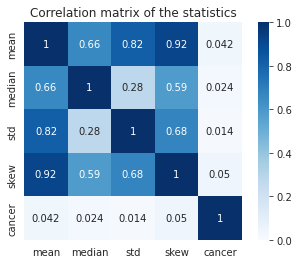

In [28]:
sns.heatmap(np.abs(stats.corr()), annot=True,
            square=True, vmin=0, vmax=1, cmap='Blues')
plt.title("Correlation matrix of the statistics")
plt.show()

As previously mentioned, means and skewness are highly correlated, while standard deviations and medians are least correlated. There is also no way to predict if a patient has cancer based on such statistics.

A Gaussian mixture model can be used to group similar images based on the statistics that have been calculated. By utilizing the tools from the `scikit-learn` library, we can implement this model. It is possible to plot again the different clusters for visualization purposes, providing a clearer understanding of how the images have been grouped.

In [29]:
scaler = StandardScaler()
X = stats.drop(['path', 'cancer'], axis=1)
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=0)
stats['cluster_label'] = gmm.fit_predict(X)

In [30]:
fig = px.scatter_3d(stats, x='mean', y='std', z='skew', color='cluster_label')
fig.show()

Let's look at a couple of images belonging to the different clusters.

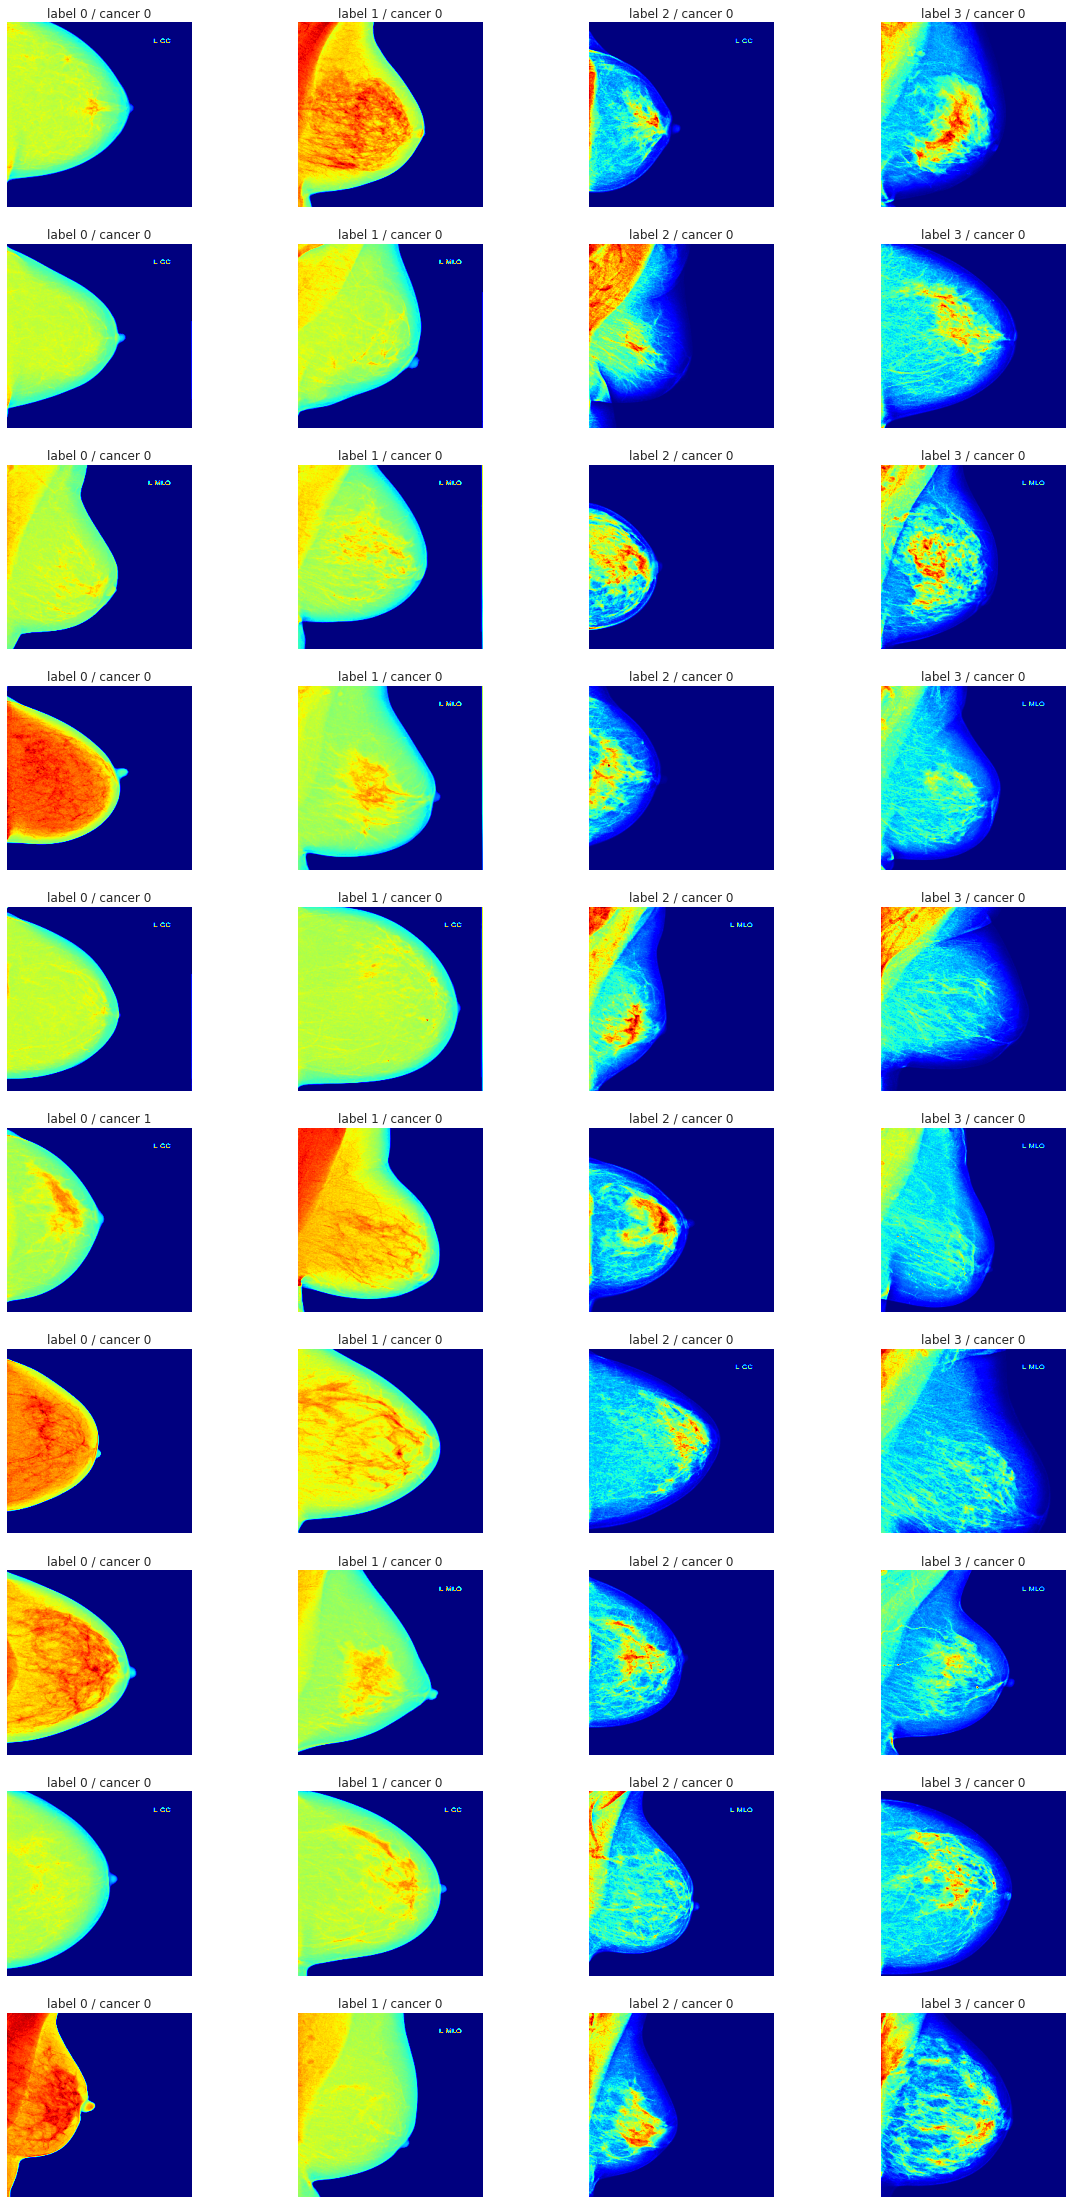

In [31]:
fig, ax = plt.subplots(10,4,figsize=(20,40))
for l in range(4):
    paths = stats[stats['cluster_label'] == l]['path'].values[0:10]
    cancers = stats[stats['cluster_label'] == l]['cancer'].values[0:10]
    for n in range(10):
        img = cv2.imread(paths[n], cv2.IMREAD_GRAYSCALE)
        ax[n,l].imshow(img, cmap='jet')
        ax[n,l].set_title(f"label {l} / cancer {cancers[n]}")
        ax[n,l].axis('off')

### Insights
- The images for a given label (along a column) are quite similar in their pixel distribution.
- The contrasts vary between clusters.

Now let's check some outliers since it was the purpose of this section. For this, let's calculate the log-likelihood of each sample. Then we check the value of the first 0.5% quantile.

In [32]:
stats['logL'] = gmm.score_samples(X)
stats['logL'].quantile(0.005)

-10.695865833714032

Let's say that the outliers we are interested in have a logL value that is less that -10 and we can display them.

In [33]:
outliers = stats[stats['logL'] < -10].sort_values(by='logL')
print(f"{len(outliers)} outliers have been found!")

11 outliers have been found!


In [34]:
outliers['path'].iloc[0]

'../input/rsna-breast-cancer-256-pngs/22689_1302203221.png'

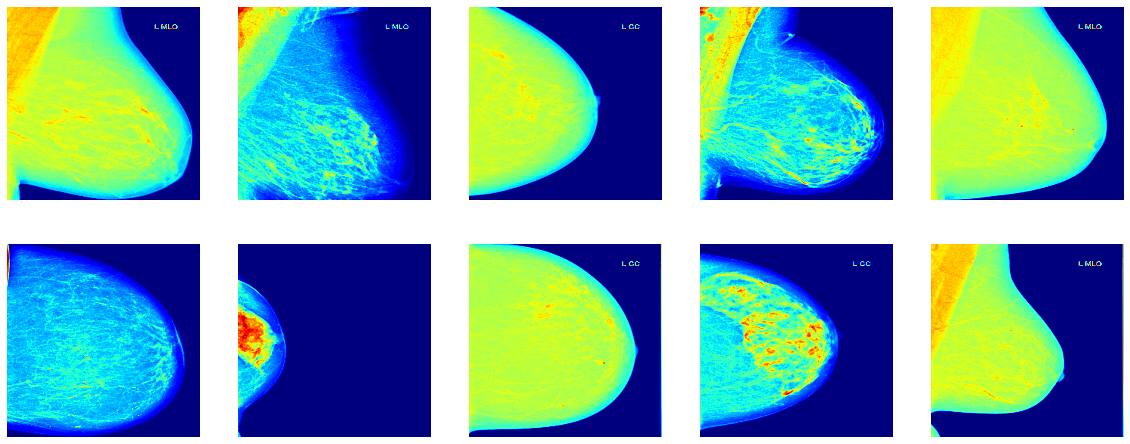

In [35]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = cv2.imread(outliers['path'].iloc[i], cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='jet')
    plt.axis('off')

### Insights
- Outliers are images where there is either a lot of background or just a little surface.
- It could also be images with a special contrast in the pixels.

I am sure that there many more outliers from other machine IDs and by taking the full set of scans for a given patient. This long work will be achieved in a future notebook.

# Conclusion
* The dataset is heavily unbalanced between scans with and without cancer.
* Most of the patients are over 40 years old.
* Images are quite large and will need to be rescaled during preprocessing.
* Pixel distributions vary significantly depending on the machine ID used.
* The dataset is also unbalanced in terms of images showing implants.
* It is very difficult for a novice to distinguish a scan with cancer from a healthy one.

Performing EDA was very informative. It helped me understand what needs to be taken into consideration during the preprocessing steps.

**Thank you for reading. I welcome any feedback you may have. 👋**